In [ ]:
from langgraph.graph import StateGraph, END ,START
from pydantic import BaseModel, Field
from langchain_core.runnables import Runnable
from typing import TypedDict, Literal, Optional
from langchain_core.messages import AIMessage, HumanMessage
import ast
from langchain_openai import AzureChatOpenAI
import os
from IPython.display import Image, display
from typing import Dict
from dotenv import load_dotenv

In [ ]:
#from langchain_community.llms import Ollama
#llm = Ollama(model="deepseek-coder:6.7b")
#base_url="http://localhost:11434"

In [ ]:



load_dotenv()


llm = AzureChatOpenAI(
    azure_endpoint=os.environ['AZURE_OPENAI_ENDPOINT'],
    azure_deployment=os.environ['AZURE_OPENAI_DEPLOYMENT_NAME'],
    openai_api_version=os.environ['AZURE_OPENAI_API_VERSION'],
    openai_api_key=os.environ['AZURE_OPENAI_API_KEY']  
)

In [20]:
from langgraph.errors import NodeInterrupt

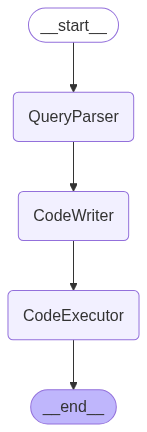

In [ ]:



class QueryFields(BaseModel):
    symbol: str = Field(..., description="Stock ticker symbol (e.g., TSLA, AAPL).")
    timeframe: str = Field(..., description="Time period (e.g., '1d', '1mo', '1y').")
    action: str = Field(..., description="Action to be performed (e.g., 'fetch', 'plot').")

class QueryAnalysisOutput(BaseModel):
    result: QueryFields
class StockAnalysisState(TypedDict):
    query: str
    parsed_output: QueryAnalysisOutput
    generated_code: Optional[str]
    execution_result: Optional[str]









def query_parser_node(state: StockAnalysisState):
    query = state["query"]
    prompt = """You are a Stock Data Analyst. Extract stock details from this user query: {query}. 
    
    """
    finalprompt=prompt.format(query=query)
    llm_with_struc=llm.with_structured_output(QueryAnalysisOutput)
    response = llm_with_struc.invoke(finalprompt)
    
    return {"parsed_output": response}

def code_writer_node(state: StockAnalysisState):
    parsed = state["parsed_output"]
    if isinstance(parsed, dict):
        raise NodeInterrupt("recieved wrong type")
    fprompt = """You are a Senior Python Developer. Generate code to {action} the stock data.
    Stock: {symbol}
    Timeframe: {timeframe}

    Use yfinance, pandas, and matplotlib libraries. Output should be a clean, executable .py Python script for stock visualization without explanations or AI-generated messages—just the direct script content.without ''' or any code blockers
    """
    action=parsed.result.action
    symbol=parsed.result.symbol
    time=parsed.result.timeframe
    ffprompt=fprompt.format(action=action,symbol=symbol,timeframe=time)
    code = llm.invoke(ffprompt)
    return {"generated_code": code}


def code_result(state: StockAnalysisState):
   
    ans=StockAnalysisState["generated_code"]
    return {"execution_result": ans}


graph = StateGraph(StockAnalysisState)

graph.add_node("QueryParser", query_parser_node)
graph.add_node("CodeWriter", code_writer_node)
graph.add_node("CodeExecutor", code_result)


graph.add_edge(START,"QueryParser")
graph.add_edge("QueryParser", "CodeWriter")
graph.add_edge("CodeWriter", "CodeExecutor")
graph.add_edge("CodeExecutor", END)


workflow = graph.compile()


display(Image(workflow.get_graph(xray=1).draw_mermaid_png()))


In [44]:
inputs = {"query": "Plot YTD stock gain of Tesla"}


result=workflow.invoke(inputs)
print(result)

{'query': 'Plot YTD stock gain of Tesla', 'parsed_output': QueryAnalysisOutput(result=QueryFields(symbol='TSLA', timeframe='YTD', action='plot')), 'generated_code': AIMessage(content='import yfinance as yf\nimport pandas as pd\nimport matplotlib.pyplot as plt\n\n# Define stock and timeframe\nstock = "TSLA"\ntimeframe = "ytd"\n\n# Fetch stock data using yfinance\ndata = yf.Ticker(stock).history(period=timeframe)\n\n# Plot stock data\nplt.figure(figsize=(12, 6))\nplt.plot(data.index, data[\'Close\'], label=f"{stock} Close Price", color=\'blue\')\nplt.title(f"{stock} Stock Price - Year to Date", fontsize=16)\nplt.xlabel("Date", fontsize=14)\nplt.ylabel("Close Price (USD)", fontsize=14)\nplt.legend(loc="upper left")\nplt.grid(alpha=0.3)\nplt.tight_layout()\n\n# Show the plot\nplt.show()', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 157, 'prompt_tokens': 81, 'total_tokens': 238, 'completion_tokens_details': {'accepted_prediction_tokens': 0, '

In [45]:
p=result["generated_code"].content

In [47]:
p

'import yfinance as yf\nimport pandas as pd\nimport matplotlib.pyplot as plt\n\n# Define stock and timeframe\nstock = "TSLA"\ntimeframe = "ytd"\n\n# Fetch stock data using yfinance\ndata = yf.Ticker(stock).history(period=timeframe)\n\n# Plot stock data\nplt.figure(figsize=(12, 6))\nplt.plot(data.index, data[\'Close\'], label=f"{stock} Close Price", color=\'blue\')\nplt.title(f"{stock} Stock Price - Year to Date", fontsize=16)\nplt.xlabel("Date", fontsize=14)\nplt.ylabel("Close Price (USD)", fontsize=14)\nplt.legend(loc="upper left")\nplt.grid(alpha=0.3)\nplt.tight_layout()\n\n# Show the plot\nplt.show()'

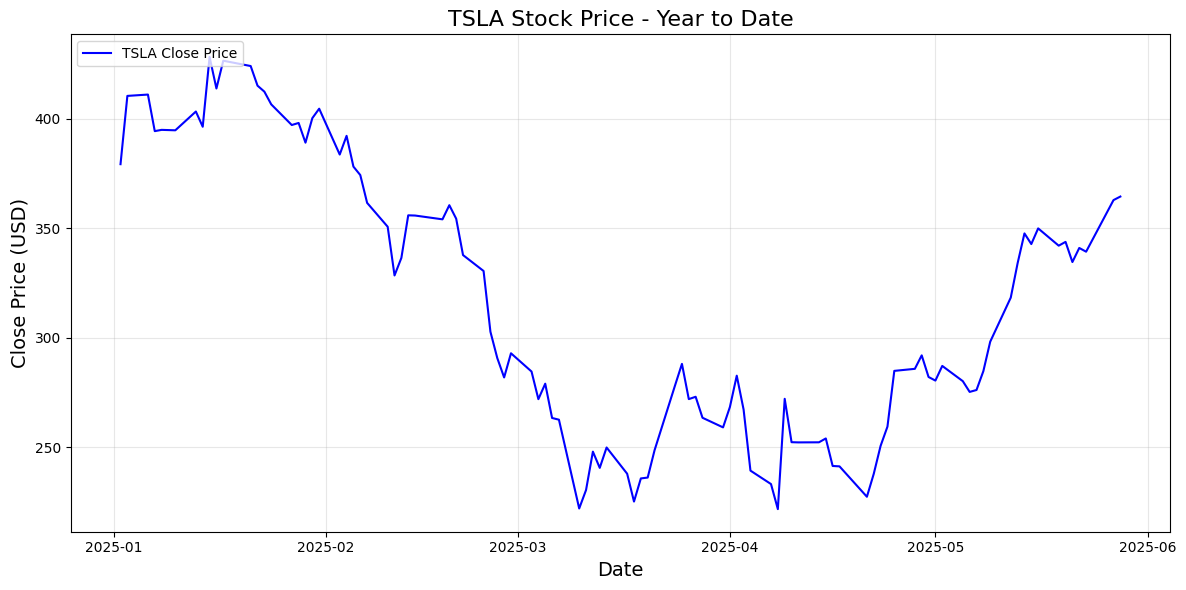

In [50]:
exec(p)